In [1]:
import structlog
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

from neural_network_scratch.gzip import read_gzip_from_path

LOGGER = structlog.get_logger()

## Data Loading

In [2]:
IMAGES_TRAIN_PATH = "data/train-images-idx3-ubyte.gz"
LABELS_TRAIN_PATH = "data/train-labels-idx1-ubyte.gz"
IMAGES_TEST_PATH = "data/t10k-images-idx3-ubyte.gz"
LABELS_TEST_PATH = "data/t10k-labels-idx1-ubyte.gz"

In [3]:
train_images_raw = read_gzip_from_path(IMAGES_TRAIN_PATH)
train_labels = read_gzip_from_path(LABELS_TRAIN_PATH)
test_images_raw = read_gzip_from_path(IMAGES_TEST_PATH)
test_labels = read_gzip_from_path(LABELS_TEST_PATH)

In [4]:
LOGGER.info(f"train images: {len(train_images_raw)}")
LOGGER.info(f"train labels: {len(train_labels)}")
LOGGER.info(f"test images: {len(test_images_raw)}")
LOGGER.info(f"test labels: {len(test_labels)}")

TOTAL_SIZE = train_images_raw[0].size
DIMENSIONS = (len(train_images_raw[0]), len(train_images_raw[0]))

LOGGER.info(f"dimensions of image: {TOTAL_SIZE} {DIMENSIONS}")

LABELS = list(set(train_labels))
LOGGER.info(f"labels: {LABELS}")

2024-02-13 21:05:47 [info     ] train images: 60000           
2024-02-13 21:05:47 [info     ] train labels: 60000           
2024-02-13 21:05:47 [info     ] test images: 10000            
2024-02-13 21:05:47 [info     ] test labels: 10000            
2024-02-13 21:05:47 [info     ] dimensions of image: 784 (28, 28)
2024-02-13 21:05:47 [info     ] labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [5]:
MAX = max([max(t.flatten()) for t in train_images_raw])

train_images = train_images_raw / MAX
test_images = test_images_raw / MAX

LOGGER.info("normalised images")

2024-02-13 21:05:50 [info     ] normalised images             


In [6]:
from neural_network_scratch import Sample

train = [
    Sample(values=train_images[i].flatten(), label=train_labels[i])
    for i in range(len(train_images))
]

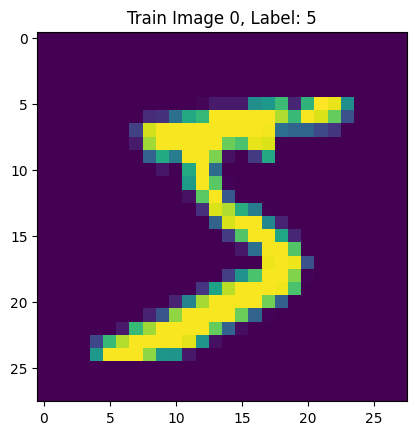

In [7]:
idx = 0
plt.imshow(train_images[idx])
plt.title(f"Train Image {idx}, Label: {train_labels[idx]}")
plt.show()

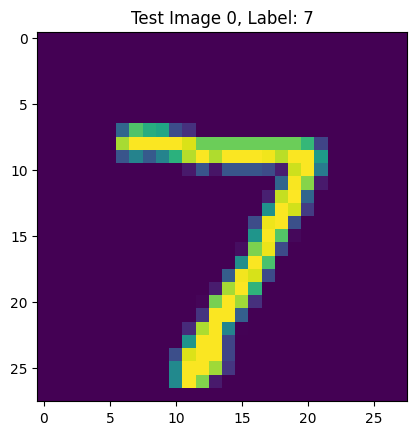

In [8]:
idx = 0
plt.imshow(test_images[idx])
plt.title(f"Test Image {idx}, Label: {test_labels[idx]}")
plt.show()

## Modelling

Given a layer of inputs $\vec{a_{i}}$, a matrix of weights $\vec{W_i}$, biases $\vec{b_i}$ and an activation function $\sigma$, the inputs fed forward to $\vec{a_{i+1}}$ are as follows:
$$\sigma \left( \vec{W_i}\vec{a_{i}} + \vec{b_i} \right)=\vec{a_{i+1}}$$

Cost function, for all weights $\vec{w}$, and for actual outputs $a^{(L)}$ and real outputs $y_i$ (for one such $k$ such that $y_k=1$, and $y_j=0  \forall j \neq k$):
$$C(\vec{w})=\Sigma_{i} (a^{(L)}_i - y_i)^2$$

Need to compute gradient descent step on a batch of the training data at a time (e.g. 10)

$$
\frac{\delta C_0}{\delta w^{(L)}}=\frac{\delta z^{(L)}}{\delta w^{(L)}}\frac{\delta a^{(L)}}{\delta z^{(L)}}\frac{\delta C_0}{\delta a^{(L)}}=2(a^{(L)}-y)\sigma' (z^{(L)})a^{(L-1)}
$$

## Two Hidden Layers

Running a network with 2 layers gets consistently worse than a single layer (see further below), likely requires many more epochs to tune all the weights.

In [10]:
from neural_network_scratch import Network

network = Network(
    input_size=TOTAL_SIZE,
    hidden_layer_sizes=[16, 16],
    number_classes=len(LABELS),
)

accuracies = network.train(
    train,
    epochs=100,
    batch_size=100,
    learning_rate=0.3,
)

2024-02-13 21:07:03 [debug    ] finished epoch 0 with accuracy of 0.09766666666666667
2024-02-13 21:07:34 [debug    ] finished epoch 10 with accuracy of 0.21766666666666667
2024-02-13 21:08:05 [debug    ] finished epoch 20 with accuracy of 0.28983333333333333
2024-02-13 21:08:35 [debug    ] finished epoch 30 with accuracy of 0.38516666666666666
2024-02-13 21:09:04 [debug    ] finished epoch 40 with accuracy of 0.44133333333333336
2024-02-13 21:09:33 [debug    ] finished epoch 50 with accuracy of 0.47983333333333333
2024-02-13 21:10:03 [debug    ] finished epoch 60 with accuracy of 0.5233333333333333
2024-02-13 21:10:32 [debug    ] finished epoch 70 with accuracy of 0.5281666666666667
2024-02-13 21:11:02 [debug    ] finished epoch 80 with accuracy of 0.5936666666666667
2024-02-13 21:11:32 [debug    ] finished epoch 90 with accuracy of 0.641


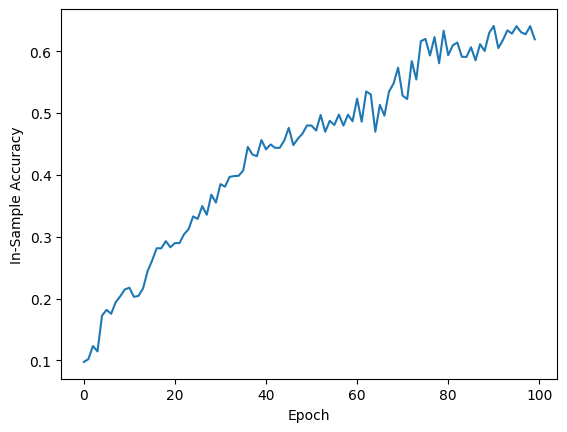

2024-02-13 21:12:01 [info     ] accuracy on test set: 0.6217  
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       980
           1       0.95      0.96      0.96      1135
           2       0.67      0.79      0.72      1032
           3       0.30      0.31      0.31      1010
           4       0.66      0.89      0.76       982
           5       0.00      0.00      0.00       892
           6       0.86      0.87      0.86       958
           7       0.75      0.89      0.81      1028
           8       0.20      0.00      0.01       974
           9       0.23      0.47      0.31      1009

    accuracy                           0.62     10000
   macro avg       0.55      0.61      0.56     10000
weighted avg       0.56      0.62      0.57     10000



In [11]:
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("In-Sample Accuracy")
plt.show()

predictions = [network.predict(x.flatten()) for x in test_images]

LOGGER.info(f"accuracy on test set: {accuracy_score(test_labels, predictions)}")

print(classification_report(test_labels, predictions, zero_division=np.nan))

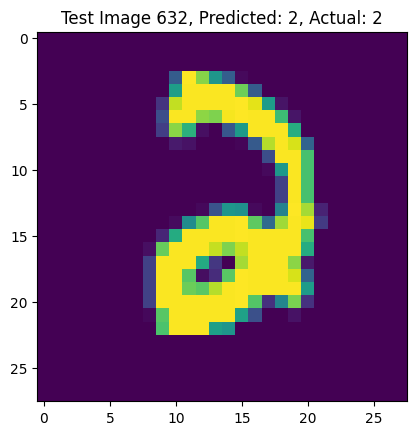

In [12]:
idx = 632
plt.imshow(test_images[idx])
plt.title(f"Test Image {idx}, Predicted: {predictions[idx]}, Actual: {test_labels[idx]}")
plt.show()

## Single Hidden Layer

In [13]:
from neural_network_scratch import Network

network = Network(
    input_size=TOTAL_SIZE,
    hidden_layer_sizes=[16],
    number_classes=len(LABELS),
)

accuracies = network.train(
    train,
    epochs=125,
    batch_size=100,
    learning_rate=0.3,
)

2024-02-13 21:12:22 [debug    ] finished epoch 0 with accuracy of 0.10383333333333333
2024-02-13 21:12:47 [debug    ] finished epoch 12 with accuracy of 0.4523333333333333
2024-02-13 21:13:12 [debug    ] finished epoch 24 with accuracy of 0.6138333333333333
2024-02-13 21:13:38 [debug    ] finished epoch 36 with accuracy of 0.6731666666666667
2024-02-13 21:14:05 [debug    ] finished epoch 48 with accuracy of 0.7078333333333333
2024-02-13 21:14:31 [debug    ] finished epoch 60 with accuracy of 0.7271666666666666
2024-02-13 21:14:58 [debug    ] finished epoch 72 with accuracy of 0.7348333333333333
2024-02-13 21:15:24 [debug    ] finished epoch 84 with accuracy of 0.7585
2024-02-13 21:15:50 [debug    ] finished epoch 96 with accuracy of 0.7661666666666667
2024-02-13 21:16:16 [debug    ] finished epoch 108 with accuracy of 0.7793333333333333
2024-02-13 21:16:42 [debug    ] finished epoch 120 with accuracy of 0.7766666666666666


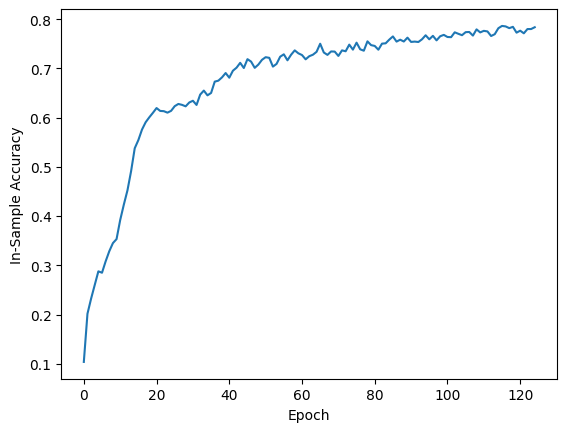

2024-02-13 21:16:54 [info     ] accuracy on test set: 0.7641  
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       980
           1       0.95      0.96      0.96      1135
           2       0.50      0.00      0.00      1032
           3       0.66      0.85      0.74      1010
           4       0.86      0.88      0.87       982
           5       0.79      0.68      0.73       892
           6       0.79      0.88      0.83       958
           7       0.88      0.86      0.87      1028
           8       0.43      0.75      0.55       974
           9       0.84      0.83      0.83      1009

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.73     10000
weighted avg       0.76      0.76      0.73     10000



In [14]:
plt.plot(accuracies)
plt.xlabel("Epoch")
plt.ylabel("In-Sample Accuracy")
plt.show()

predictions = [network.predict(x.flatten()) for x in test_images]

LOGGER.info(f"accuracy on test set: {accuracy_score(test_labels, predictions)}")

print(classification_report(test_labels, predictions, zero_division=np.nan))